In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'give me',
    'not give me',
]

data = np.concatenate([
    np.load('dataset/seq_give_me_1683794228.npy'),
    np.load('dataset/seq_not_give_me_1683794228.npy'),
], axis=0)

data.shape

(1979, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1979, 30, 99)
(1979,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1979, 2)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1781, 30, 99) (1781, 2)
(198, 30, 99) (198, 2)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, activation='tanh', input_shape=x_train.shape[1:3], dropout=0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax')
    
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               116736    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 183,810
Trainable params: 183,810
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 0.0827 - acc: 0.9736
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models/model.h5
56/56 [==============================] - 5s 46ms/step - loss: 0.0827 - acc: 0.9736 - val_loss: 0.0037 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 0.0047 - acc: 0.9989
Epoch 2: val_acc did not improve from 1.00000
56/56 [==============================] - 3s 63ms/step - loss: 0.0047 - acc: 0.9989 - val_loss: 0.0013 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
55/56 [============================>.] - ETA: 0s - loss: 4.1659e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
56/56 [==============================] - 2s 37ms/step - loss: 4.1258e-04 - acc: 1.0000 - val_loss: 2.8545e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
55/56 [============================>.] - ETA: 0s - loss: 2.6720e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
56/56 [

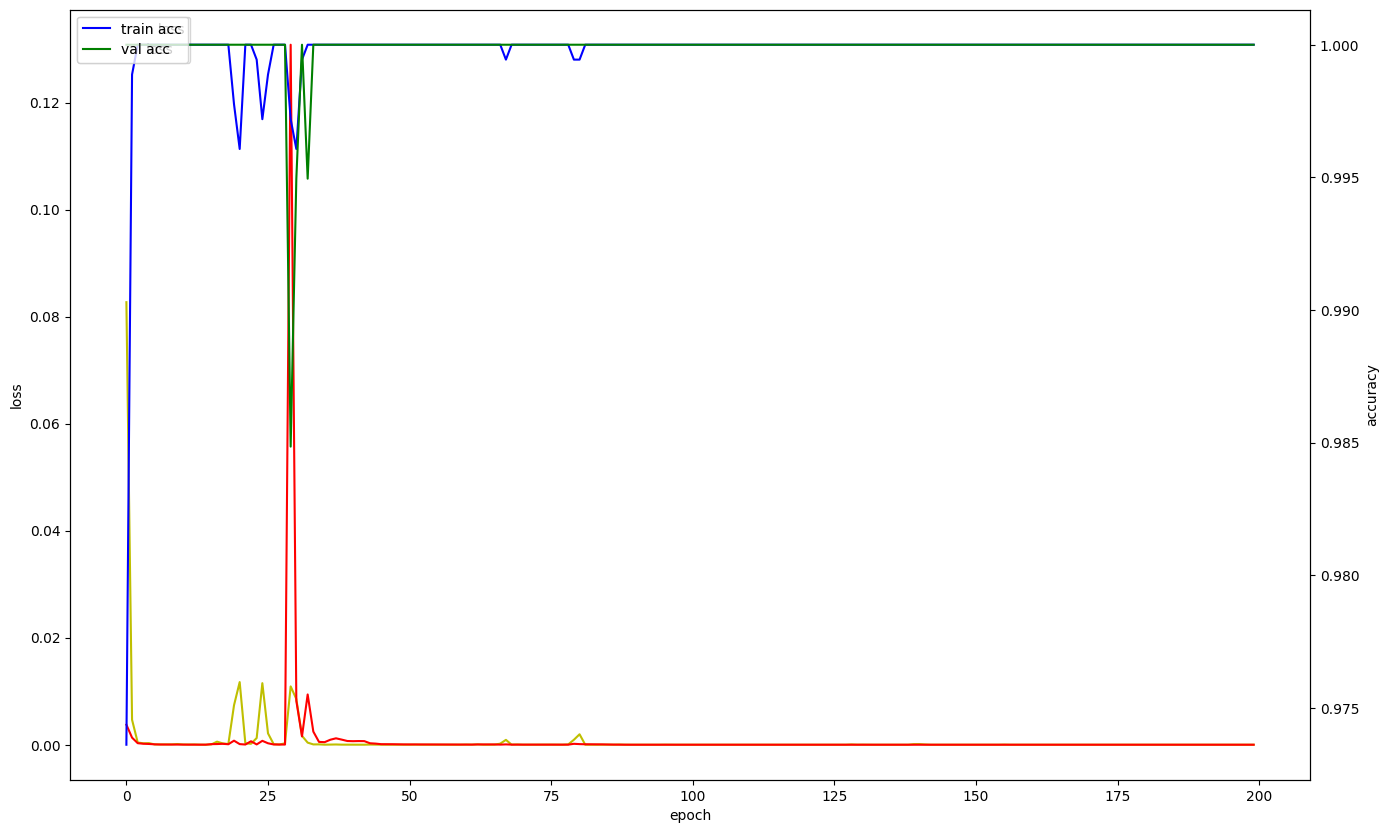

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 [==============================] - 0s 11ms/step


array([[[103,   0],
        [  0,  95]],

       [[ 95,   0],
        [  0, 103]]])